In [26]:
from eye_tracking_utils import inspect_video_vs_code_text

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# %%
USER_NAME = "UconsumerU"
USER_ZOOM = "M"
VIDEO_FILE = "../participants/UconsumerU/video_export_07-26-22-15.10.UconsumerU 0.avi"
USER_FOLDER = "../participants/UconsumerU"
EYE_TRACKER_FILE = "../participants/UconsumerU/UconsumerU 0_fixations.csv"

../config/annotation_UconsumerU_0.yaml
Earliest Eye-Tracker Data (millisec):  52858779.0


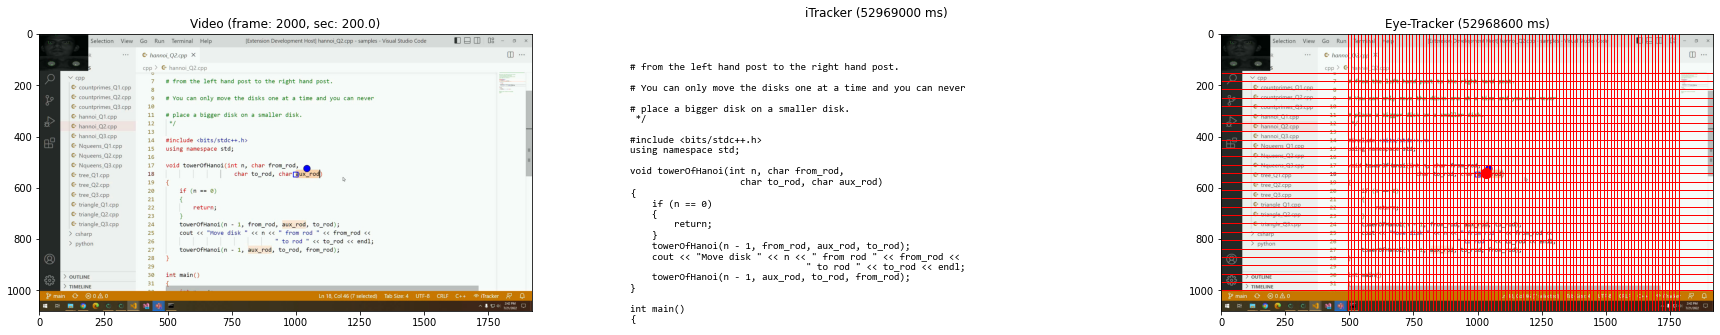

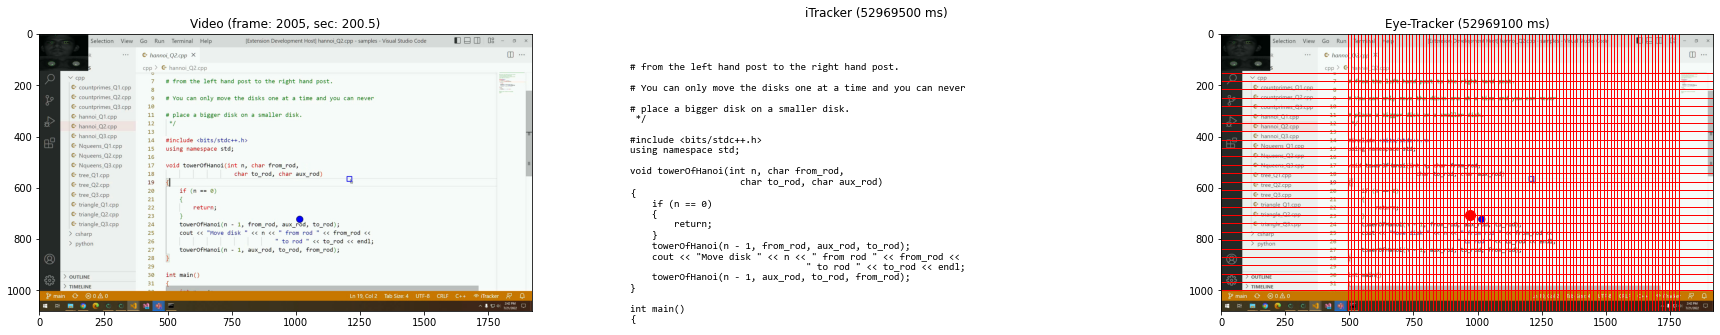

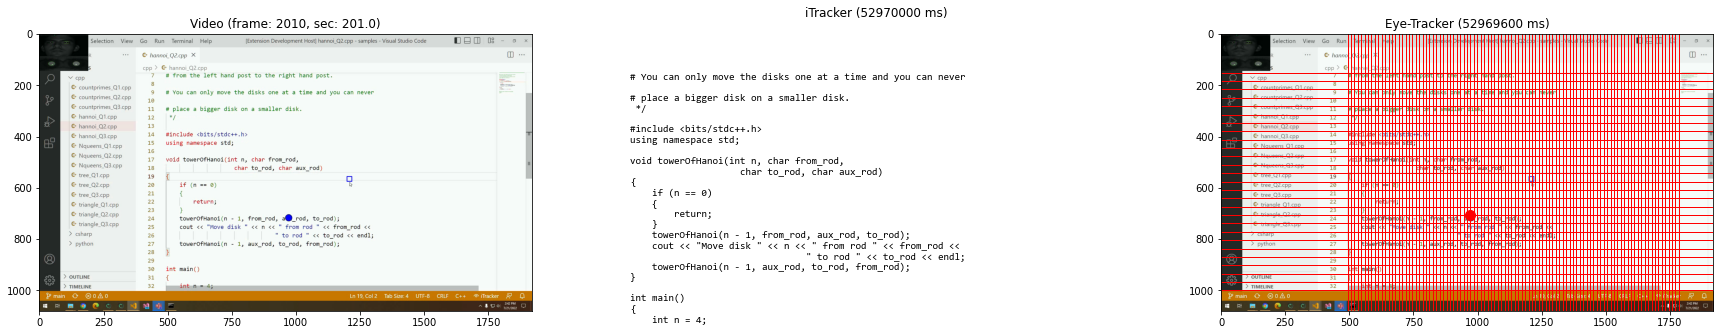

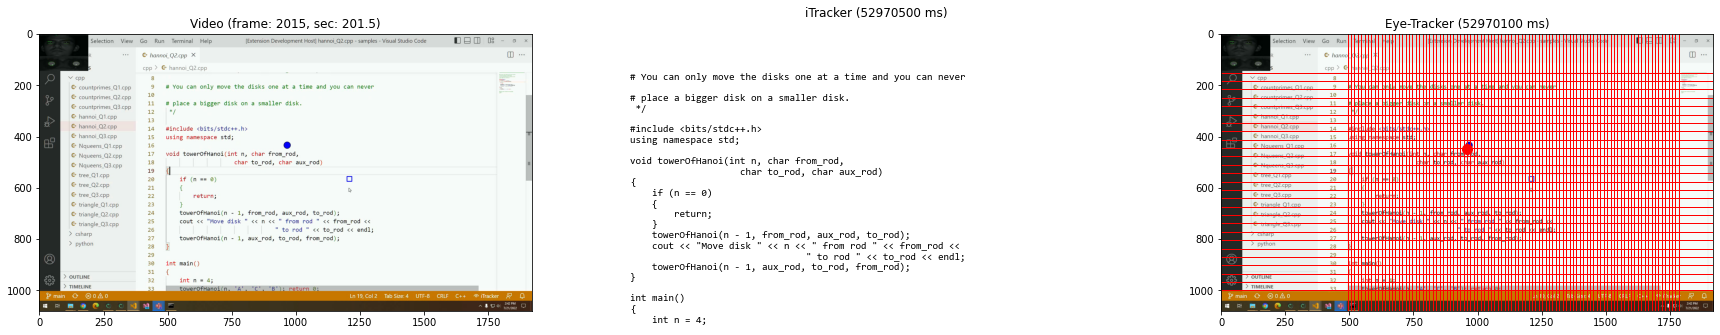

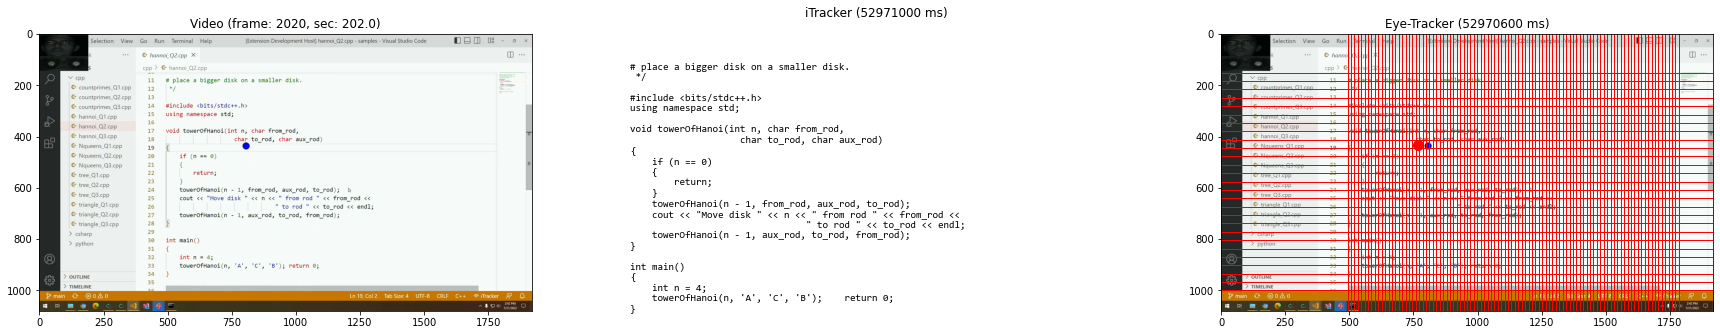

In [30]:

inspect_video_vs_code_text(
    user_folder=f"../participants/{USER_NAME}",
    user_zoom=USER_ZOOM,
    task_nr=0,
    every_n_millisec=500,
    start_millisec=200000,
    n_samples=5
)

In [31]:
SOURCE_FILE = "../samples/cpp/hannoi_Q2.cpp"
# read file
with open(SOURCE_FILE, "r") as f:
    SOURCE_CODE = f.read()

In [32]:
from eye_tracking_utils import read_textual_snapshot
df_snap = read_textual_snapshot(user_folder=USER_FOLDER)
df_snap.head()

,time,source_filename,content_lines
0,52861870.0,c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...,"[\n, # You can only move the disks one at a ti..."
1,53784778.0,c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...,"[{\n, \tif (a + b > c)\n, \t\treturn ""acute"";\..."
2,52893420.0,c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...,[# In the Tower of Hanoi problem you have to m...
3,53813552.0,c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...,"[\t\treturn ""Scalene"";\n, }\n, \n, string getA..."
4,53743264.0,c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...,"[\n, \tp1 = point(0, 0);\n, \tp2 = point(1, 1)..."


In [33]:
import re
from typing import List, Any, Tuple

record = df_snap.iloc[0].to_dict()
line_start = int(re.search(":([0-9]+)\n$", record["source_filename"]).group(1))
line_start

7

In [34]:
file_path = record["source_filename"]
file_name = re.search("([a-zA-Z0-9 _.]+):[0-9]+\n$", file_path).group(1)
folder = re.search("\\\\([a-zA-Z]+)\\\\[a-zA-Z0-9 _.]+:[0-9]+\n$", file_path).group(1)

In [35]:
from eye_tracking_utils import extract_attention_map_char_level

target_file, all_attended_tokens = extract_attention_map_char_level(
    user_folder=f"../participants/{USER_NAME}",
    user_zoom=USER_ZOOM,
    task_nr=0,
    every_n_millisec=100,
    #start_millisec=209000,
    #n_samples=20,
    horizontal_attention_span=6,
    vertical_attention_span=1,
    debug=False
)

video: ../participants/UconsumerU/video_export_07-26-22-15.10.45_UconsumerU 0.avi
../config/annotation_UconsumerU_0.yaml
Earliest Eye-Tracker Data (millisec):  52858779.0


100%|██████████| 1770/1770 [00:04<00:00, 416.48it/s]

There were 181 fixations outside the code area.


In [36]:
from codeattention.source_code import SourceCode
import pandas as pd

In [37]:
char_records = [{"line": c[0], "column": c[1]} for c in all_attended_tokens]
df = pd.DataFrame.from_records(char_records)
df = df.groupby(by=["line", "column"]).size().reset_index(name="count")
df = df.sort_values(by="count", ascending=False)
df.head()

,line,column,count
220,4,9,132
1536,31,9,130
221,4,10,129
151,3,7,129
153,3,9,129


In [38]:
from pprint import pprint

def replace_only_starting_characters(line: str, n_spaces_per_tab: int = 4):
    """Remove only starting tab characters like vscode does."""
    new_line = line
    if new_line.startswith("\t"):
        new_line = new_line.replace("\t", " " * n_spaces_per_tab, 1)
    return new_line


def add_character_based_on_source_file(
        df: pd.DataFrame, 
        source_file_path: str,
        tot_screen_lines: int = 26,
        tot_screen_col: int = 97,):
    """Add a token column based on the `line` and `column` columns.
    
    The token represents the character at the `line` and `column` position
    in the input source file.
    The input source code file will be padded to reach the desired line length
    (i.e. by adding spaces) and file length (i.e. by adding lines).
    """
    with open(source_file_path, "r") as f:
        source_code = f.read()
    source_code_lines = source_code.split("\n")
    padded_lines = []
    for i, line_content in enumerate(source_code_lines):
        padded_lines.append(
            replace_only_starting_characters(line_content).replace("\t", " ") + 
            " " * (tot_screen_col - len(line_content)))
    # add empty lines at the end of the file
    padded_lines.extend(
        [" " * tot_screen_col for _ in range(tot_screen_lines)])
    df["token"] = df.apply(
        lambda row: padded_lines[row["line"] - 1][row["column"] - 1],
        axis=1
    )
    return df

df_w_token = add_character_based_on_source_file(
    df, source_file_path=SOURCE_FILE, tot_screen_lines=26, tot_screen_col=97)
df_w_token.head()


,line,column,count,token
220,4,9,132,
1536,31,9,130,
221,4,10,129,
151,3,7,129,
153,3,9,129,


In [39]:
df_w_token_sorted = df_w_token.sort_values(by=["line", "column"])
formatted_tokens = df_w_token_sorted.rename(
    columns={"line": "l", "column": "c", "token": "t", "count": "w"}
).to_dict(orient="records")
formatted_tokens = [
    {'i': i, **ft} for i, ft in enumerate(formatted_tokens)
]
formatted_tokens[:5]

[{'i': 0, 'l': 0, 'c': 1, 'w': 4, 't': ' '},
 {'i': 1, 'l': 0, 'c': 2, 'w': 9, 't': ' '},
 {'i': 2, 'l': 0, 'c': 3, 'w': 9, 't': ' '},
 {'i': 3, 'l': 0, 'c': 4, 'w': 9, 't': ' '},
 {'i': 4, 'l': 0, 'c': 5, 'w': 9, 't': ' '}]

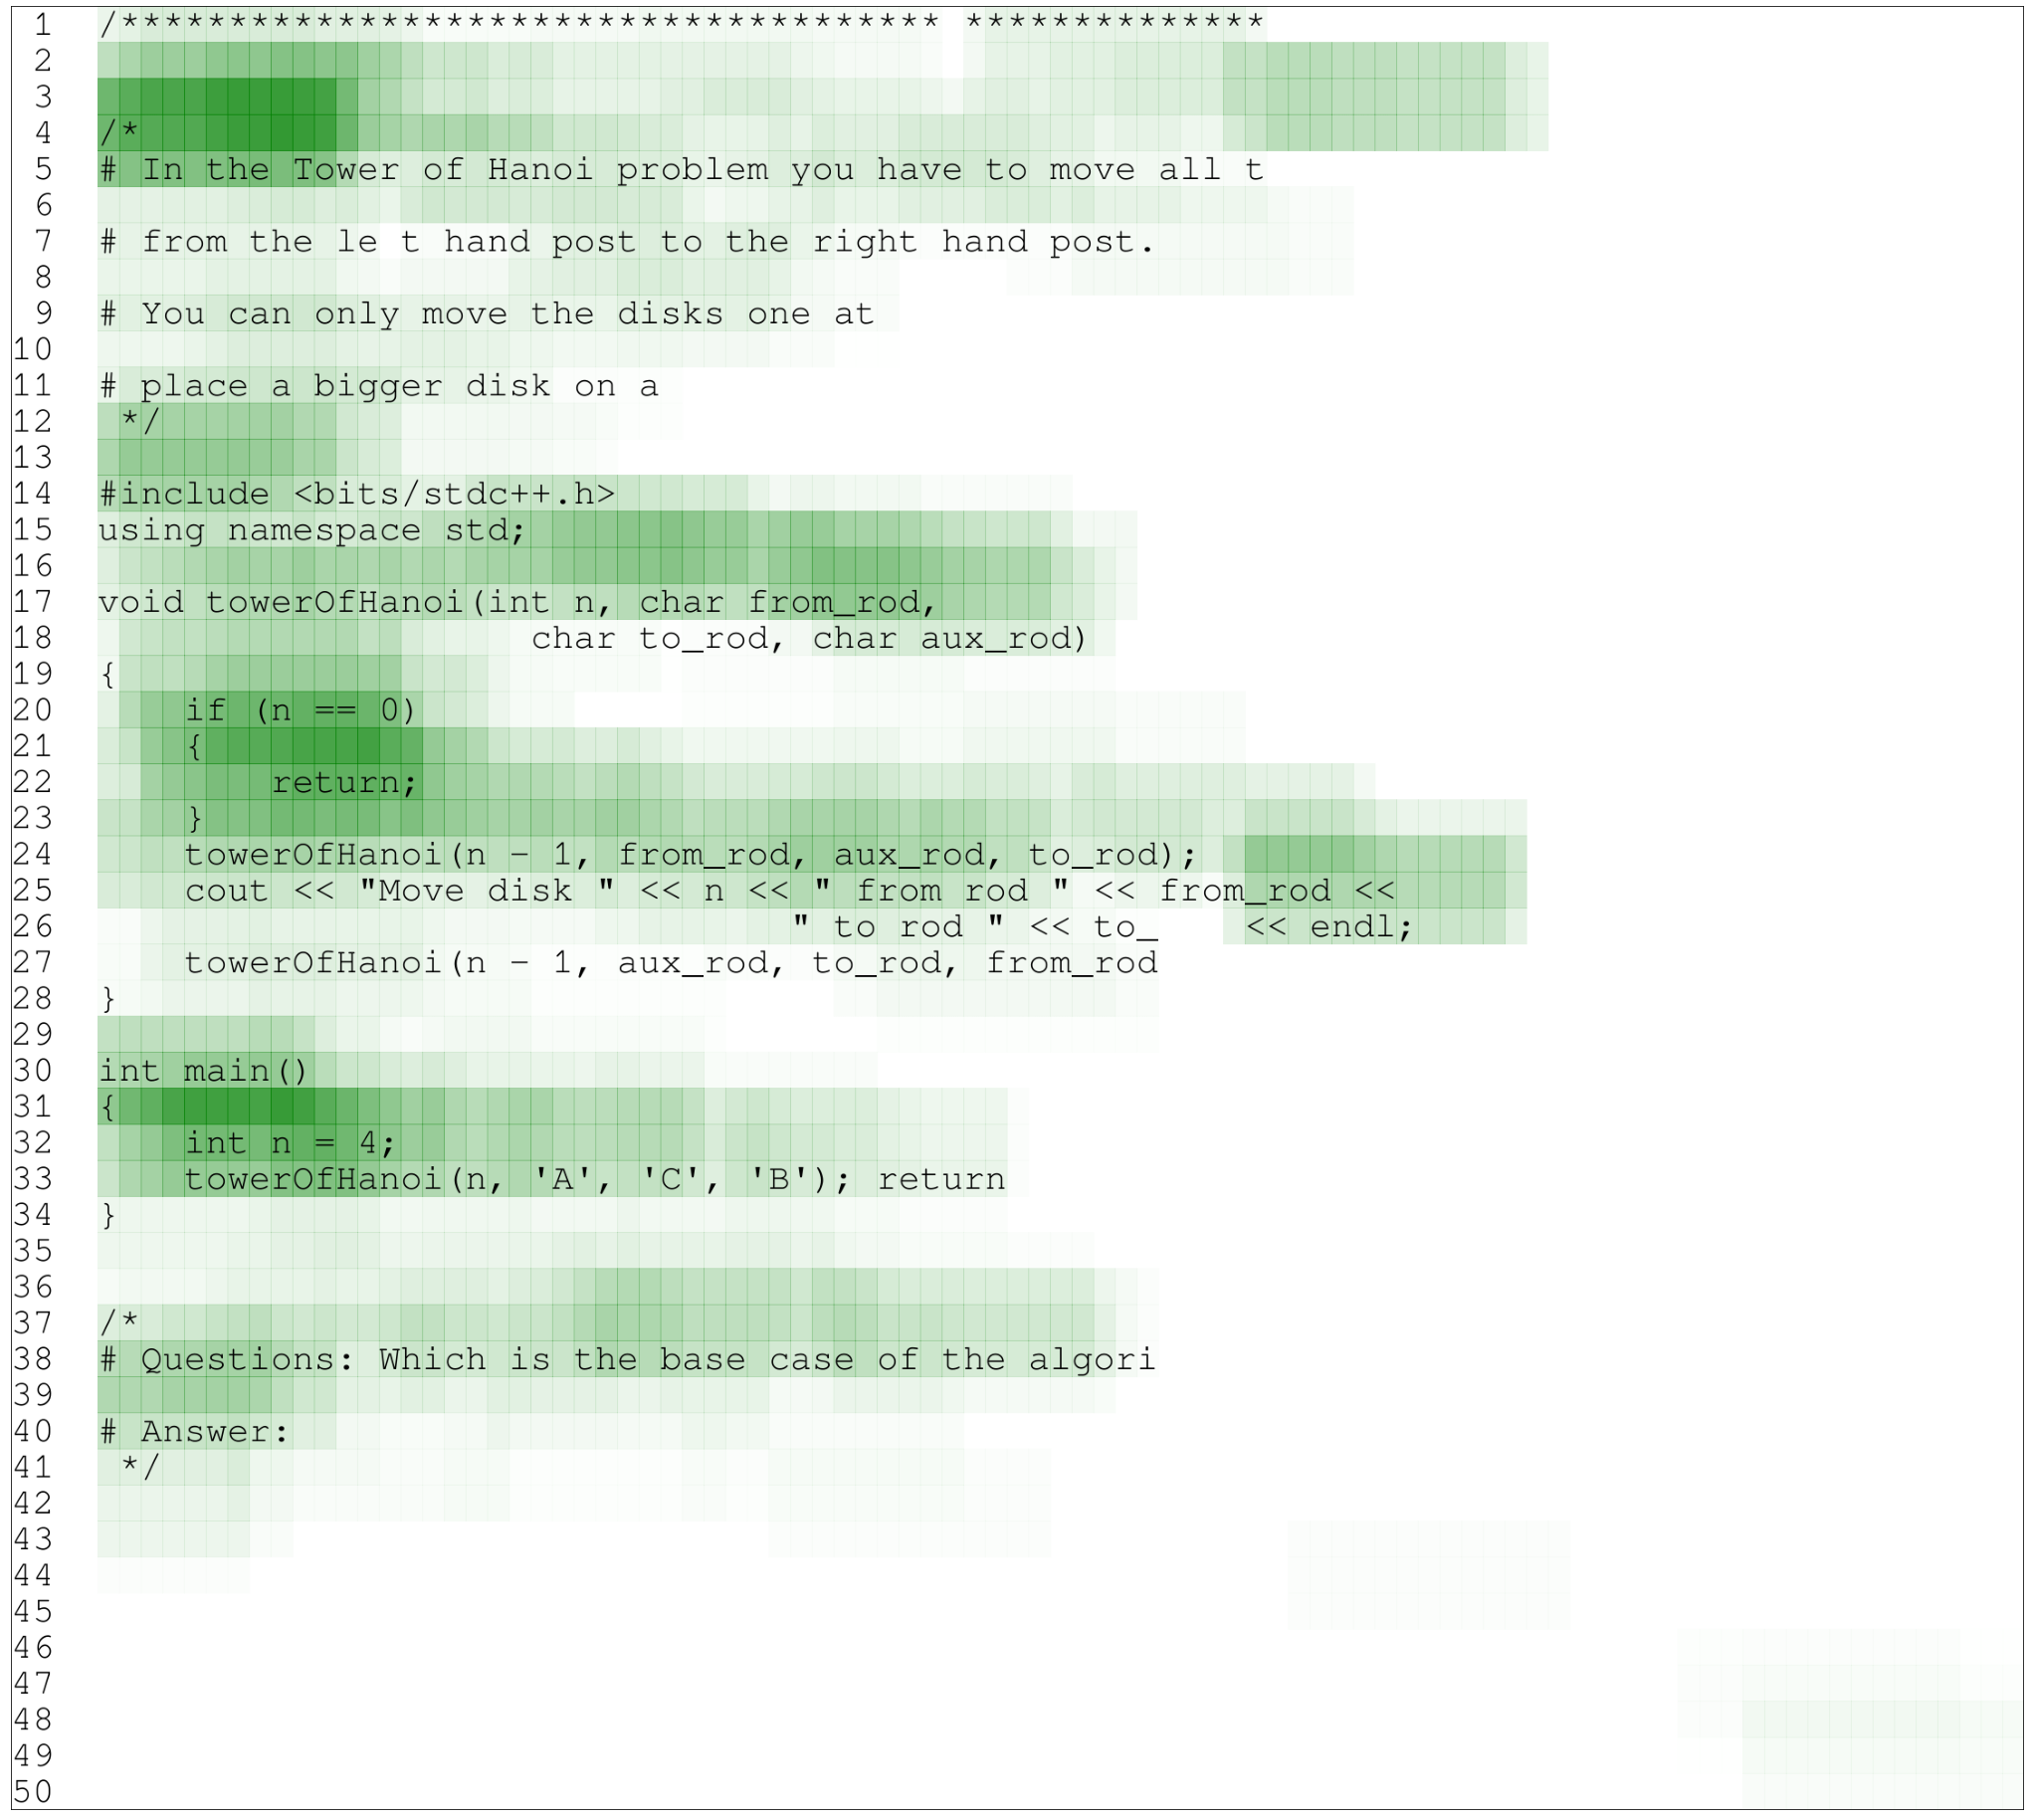

In [40]:
my_source_code = SourceCode(formatted_tokens)

weights = [ft["w"] for ft in formatted_tokens]

fig, ax = my_source_code.show_with_weights(
    weights=weights, show_line_numbers=True)

In [41]:
#fig.savefig(f"../attentions/{USER_NAME}_task_0.png")